In [122]:
import pickle
import numpy as np

bsnipdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/BSNIP/'
bsnipdemo = pickle.load(open(f'{bsnipdir}/demographics.pkl', 'rb'))
bsniptopdir = '/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/BSNIP/'

fc = []
aps20 = []
aps15 = []
aps10 = []
aps5 = []
aps3 = []
aps1 = []
age = []
sex = []
race = []
sz = []

for sub in bsnipdemo['Age_cal']:
    try:
        a = bsnipdemo['Age_cal'][sub]
        s = bsnipdemo['sex'][sub]
        r = bsnipdemo['Race'][sub]
        d = bsnipdemo['DXGROUP_1'][sub]
        if d not in ['NC', 'SZP']:
            continue
        if r not in ['AA', 'CA']:
            continue
        s = s == 's1.0'
        r = r == 'AA'
        d = d == 'SZP'
        age.append(a)
        sex.append(s)
        race.append(r)
        sz.append(d)
        fc.append(np.load(f'{bsnipdir}/fc/{sub}_task-unk_fc.npy'))
        aps20.append(np.load(f'{bsniptopdir}/Top20/{sub}_task-unktop20_fc.npy'))
        aps3.append(np.load(f'{bsniptopdir}/Top3/{sub}_task-unktop3_fc.npy'))
        aps1.append(np.load(f'{bsniptopdir}/Top1/{sub}_task-unktop1_fc.npy'))
    except:
        pass

age = np.stack(age)
sex = np.stack(sex).astype('int')
race = np.stack(race).astype('int')
sz = np.stack(sz).astype('int')
fc = np.stack(fc)
aps20 = np.stack(aps20)
aps1 = np.stack(aps1)

print([x.shape for x in [age, sex, race, sz, fc, aps20, aps1]])

[(405,), (405,), (405,), (405,), (405, 34716), (405, 34716), (405, 34716)]


In [63]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split

def rmse(yhat, y):
    return np.mean((yhat-y)**2)**0.5

accs = []
nulls = []

for i in range(10):
    # Try mixup
    
    idcs = np.random.permutation(len(aps1))
    mixed = aps20-0.2*aps1+0.2*aps1[idcs]
    
    xtr, xt, ytr, yt = train_test_split(mixed, sex, stratify=sex, train_size=0.8)

    # reg = Ridge(alpha=1).fit(xtr, ytr)
    # yhat = reg.predict(xt)
    # acc = rmse(yhat, yt)
    # null = rmse(np.mean(ytr), yt)
    # print(acc, null)

    reg = LogisticRegression(C=1, max_iter=1000).fit(xtr, ytr)
    yhat = reg.predict(xt)
    acc = np.mean(yhat == yt)
    null = np.mean(yt)
    if null < 0.5:
        null = 1-null
    print(acc, null)

    accs.append(acc)
    nulls.append(null)

print('---')
print(np.mean(accs))
print(np.mean(nulls))

0.7530864197530864 0.5432098765432098
0.7283950617283951 0.5432098765432098
0.7037037037037037 0.5432098765432098
0.6666666666666666 0.5432098765432098
0.654320987654321 0.5432098765432098
0.654320987654321 0.5432098765432098
0.6666666666666666 0.5432098765432098
0.7160493827160493 0.5432098765432098
0.7654320987654321 0.5432098765432098
0.6419753086419753 0.5432098765432098
---
0.6950617283950618
0.5432098765432098


In [123]:
# Find empirical mutual information

from sklearn.metrics.pairwise import euclidean_distances

N = len(fc)

x = aps3-aps1 #np.random.normal(size=(N, 34716))
x = x - np.mean(x, axis=0, keepdims=True)
dx = euclidean_distances(x)
# dx = dx[dx > 0.001]
sx = np.std(dx)
mx = np.mean(dx)
print(sx, mx)

y = sz
y = np.expand_dims(y - np.mean(y), 1)
dy = euclidean_distances(y)
sy = 0.5*np.std(dy)
my = np.mean(dy)
print(sy, my)

p = 0

for i in range(N):
    xi = x[i:i+1]
    yi = y[i:i+1]
    dxi = euclidean_distances(xi, x)
    a = dxi < (mx-sx)
    dyi = euclidean_distances(yi, y)
    b = dyi < (my-sy)
    c = a*b
    p += np.log(np.sum(c)*N/np.sum(b)/np.sum(a))
    if i%100 == 0:
        print(f'Done {i} {p}')

print(p)

5.12315580866884 30.787816421620978
0.24999302782701835 0.49626581313824103
Done 0 0.7835312420282142
Done 100 22.38270744754647
Done 200 59.461123586176036
Done 300 86.34791291577342
Done 400 96.85272436938108
97.26766954945347


In [44]:
nx, ny, nxy

(17141, 28079, 3589)

# Mutual Information

# Age
- 11.755405915034213 random Gaussian
- 118.9762486869882 fc
- 104.68006537485854 aps1
- 119.18789027121039 aps20
- 131.84321219675988 aps20-aps1
- 129.9191387233695 fc-aps1

# Sex
- 15.759411155635313 random Gaussian
- 88.22025877472836 fc 
- 83.63518878322546 aps1 
- 87.60736797895963 aps20 
- 91.47227217140231 aps20-aps1 
- 91.07479800444804 fc-aps1 

# Race 
- 5.341035232040504 random Gaussian
- 95.139540984524 fc 
- 81.286118602034 aps1
- 93.623680219314 aps20
- 100.14754383136 aps20-aps1
- 101.42651103802069 fc-aps1 

# SZ
- 11.48694228176085 random Gaussian
- 103.49155046290215 fc
- 86.22777580303065 aps1
- 102.57837866447328 aps20
- 106.04889032464408 aps20-aps1
- 104.78782652922564 fc-aps1

/tmp/ipykernel_80486/521720473.py:37: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


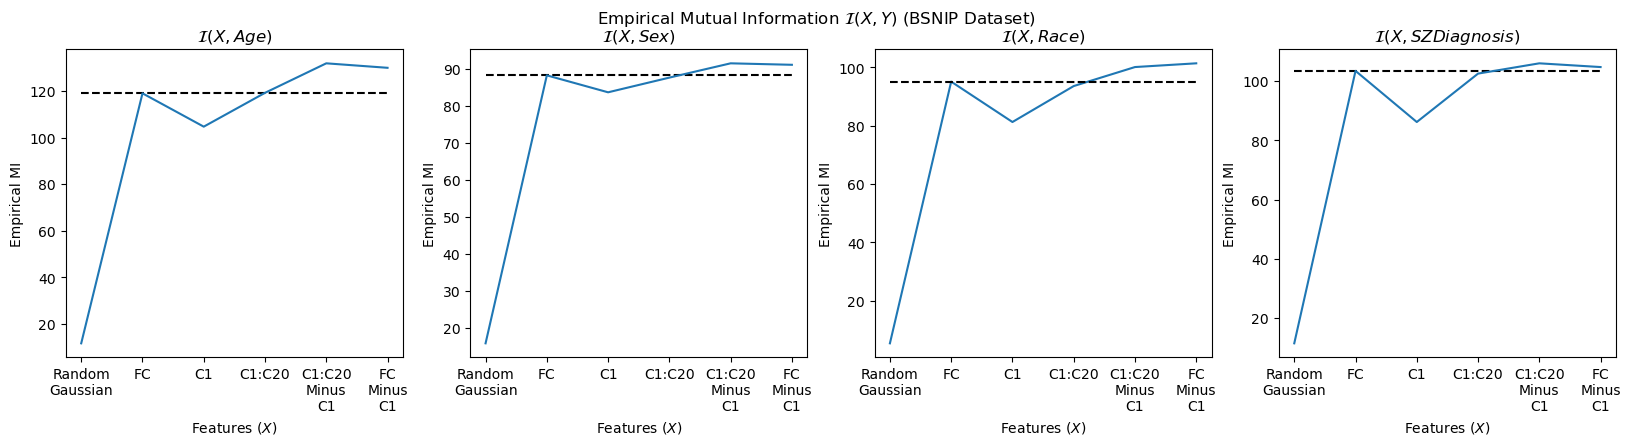

In [119]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,4,figsize=(20,4))

age = [11.755405915034213, 118.9762486869882, 104.68006537485854, 119.18789027121039, 131.84321219675988, 129.9191387233695]
sex = [15.759411155635313, 88.22025877472836, 83.63518878322546, 87.60736797895963, 91.47227217140231, 91.07479800444804]
race = [5.341035232040504, 95.139540984524, 81.286118602034, 93.623680219314, 100.14754383136, 101.42651103802069]
sz = [11.48694228176085, 103.49155046290215, 86.22777580303065, 102.57837866447328, 106.04889032464408, 104.78782652922564]

labels = ['Random\nGaussian', 'FC', 'C1', 'C1:C20', 'C1:C20\nMinus\nC1', 'FC\nMinus\nC1']

ax[0].plot([0,5],[age[1],age[1]],linestyle='--',color='black')
ax[0].plot(labels, age)
ax[0].set_title('$\\mathcal{I}(X,Age)$')
ax[0].set_xlabel('Features ($X$)')
ax[0].set_ylabel('Empirical MI')

ax[1].plot([0,5],[sex[1],sex[1]],linestyle='--',color='black')
ax[1].plot(labels, sex)
ax[1].set_title('$\\mathcal{I}(X,Sex)$')
ax[1].set_xlabel('Features ($X$)')
ax[1].set_ylabel('Empirical MI')

ax[2].plot(labels, race)
ax[2].plot([0,5],[race[1],race[1]],linestyle='--',color='black')
ax[2].set_title('$\\mathcal{I}(X,Race)$')
ax[2].set_xlabel('Features ($X$)')
ax[2].set_ylabel('Empirical MI')

ax[3].plot([0,5],[sz[1],sz[1]],linestyle='--',color='black')
ax[3].plot(labels, sz)
ax[3].set_title('$\\mathcal{I}(X,SZ Diagnosis)$')
ax[3].set_xlabel('Features ($X$)')
ax[3].set_ylabel('Empirical MI')

fig.suptitle('Empirical Mutual Information $\\mathcal{I}(X,Y)$ (BSNIP Dataset)')
fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/ContrastiveLearning/mutual_info_graph.pdf')